# 第10章 数据聚合与分组运算

对__数据集__进行__分组__并对__各组__应用__一个函数__(无论是__聚合__还是__转换__)，通常是__数据分析工作__中的__重要环节__。在将数据集__加载、融合、准备好__之后，通常就是__计算分组统计__或__生成透视表__。

pandas提供了一个灵活高效的__gruopby功能__，它使你能以一种__自然的方式__对__数据集__进__行切片、切块、摘要__等操作。



__关系型数据库和SQL__(Structured Query Language，结构化查询语言)能够__如此流行__的__原因之一__就是其能够方便地对__数据__进行__连接、过滤、转换和聚合__。但是，像__SQL__这样的__查询语言__所能执行的__分组运算的 种类 很有限__。

在本章中你将会看到，由于__Python和pandas__强大的__表达能力__，我们可以执行__复杂得多的 分组运算__(利用__任何__可以接受__pandas对象或NumPy数的   函数__)。在本章中，你将会学到：
- 使用__一个或多个键__(以函数、数组或DataFrame列名的形式)将__panda对象__分割为__多个部分__
- 计算__分组 摘要统计__，如计数、平均值、标准差，或用户__自定义函数__
- 应用__组内转换 或 其他运算__，如规格化、线性回归、排名或选取子集等
- 计算__透视表 或 交叉表__
- 执行__分位数分析__以及__其它统计分组分析__

笔记：对__时间序列数据__的__聚合__(groupby的__特殊用法__之一)也称作__重采样__(resampling)，本书将在第__11章__中__单独__对其进行__讲解__。

# 1.GroupBy机制

adley Wickham(许多热门R语言包的作者)创造了一个用于表示__分组运算的 术语 "split-apply-combine"(拆分－应用－合并)__。
- 第一个阶段，__pandas对象__(无论是__Series、DataFrame__还是__其他__的)中的__数据__会__根据__你所提供的__一个或多个键 被拆分(split)__为__多组__。__拆分操作__是在__对象__的__特定轴__上执行的。例如，__DataFrame__可以在__其行(axis=0) 或 列(axis=1)__上进行__分组__。
- 然后，将__一个函数 应用(apply)到 各个分组__并产生一个__新值__。
- 最后，所有__这些函数__的__执行结果__会被__合并(combine)__到**最终**的**结果对象**中。**结果对象的 形式**一般取决于数据上**所执行的操作**。

图10-1大致说明了一个__简单的 分组聚合过程__。

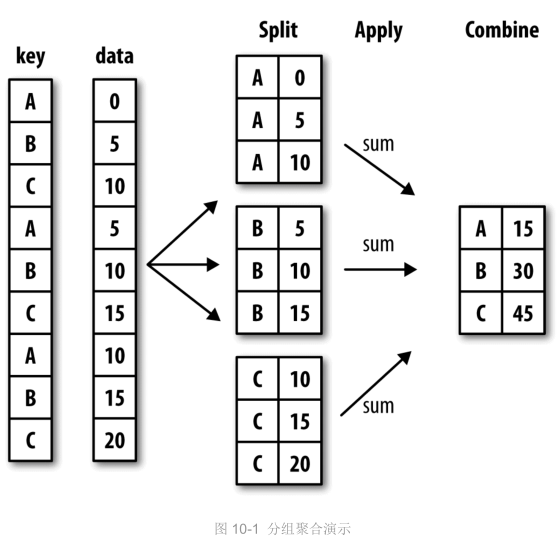

__分组键__可以有__多种形式__，且__类型不必相同__：
- __列表或数组__，其__长度__与__待分组的轴__一样。
- 表示__DataFrame 某个列名__的值。
- __字典或Series__，给出__待分组轴上的值__与__分组名__之间的__对应关系__。
- __函数__，用于处理__轴索引__或__索引中的 各个标签__。

注意，__后三种__都只是__快捷方式__而已，其__最终目的__仍然是产生__一组 用于拆分对象的值__。

如果觉得这些东西看起来很抽象，不用担心，将在本章中给出大量有关于此的示例。首先来看看下面这个非常简单的__表格型数据集__(以__DataFrame__的形式)：

In [164]:
import pandas as pd
import numpy as np

In [2]:
df = pd.DataFrame({'key1': ['a', 'a', 'b', 'b', 'a'],
                  'key2': ['one', 'two', 'one', 'two', 'one'],
                  'data1': np.random.randn(5),
                  'data2': np.random.randn(5)})
df

,key1,key2,data1,data2
0,a,one,0.319679,-1.054333
1,a,two,2.048880,1.130118
2,b,one,-1.009887,0.464170
3,b,two,-0.064568,0.179669
4,a,one,-1.176650,1.287164


假设你想要按__key1__进行__分组__，并计算__data1列__的__平均值__。实现__该功能的 方式 有很多__，而我们这里__要用的是__：__访问data1__，并__根据key1 调用groupby__：

In [3]:
grouped = df['data1'].groupby(df['key1'])

grouped

变量grouped是一个__GroupBy对象__。它__实际上 还没有进行任何计算__，只是__含有__一些__有关分组键df['key1']的 中间数据__而已。换句话说，__该对象__已经有了接下来对__各分组执行运算 所需的 一切信息__。
- 例如，我们可以调用__GroupBy的 mean方法__来计算__分组平均值__：

In [4]:
grouped.mean()

key1
a    0.397303
b   -0.537228
Name: data1, dtype: float64

稍后将__详细讲解 .mean()的 调用过程__。这里__最重要__的是，__数据(Series)__根据__分组键__进行了__聚合__，产生了一个__新的Series__，其__索引__为__key1列__中的__唯一值__。之所以__结果中索引的 名称 为key1__，是因为__原始DataFrame的列df['key1']__就叫这个名字。
- 如果我们一次传入__多个数组的 列表__，就会得到__不同的 结果__：

In [5]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()

means

key1  key2
a     one    -0.428486
      two     2.048880
b     one    -1.009887
      two    -0.064568
Name: data1, dtype: float64

- 这里，通过__两个键__对__数据__进行了__分组__，得到的__Series__具有一个__层次化索引__(由__唯一的键对__组成)：

In [6]:
means.unstack()

key2,one,two
key1,,
a,-0.428486,2.048880
b,-1.009887,-0.064568


- 在这个例子中，__分组键__均为__Series__。实际上，__分组键__可以是__任何长度适当的 数组__：

In [7]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])

In [8]:
df['data1'].groupby([states, years]).mean()

California  2005    2.048880
            2006   -1.009887
Ohio        2005    0.127555
            2006   -1.176650
Name: data1, dtype: float64

- 通常，__分组信息__就位于__相同的 要处理的DataFrame中__。这里，你还可以将__列名__(可以是__字符串、数字或其他Python对象__)用作__分组键__：

In [10]:
df.groupby('key1').mean()

,data1,data2
key1,,
a,0.397303,0.454317
b,-0.537228,0.321919


In [11]:
df.groupby(['key1', 'key2']).mean()

data1     data2
key1 key2                    
a    one  -0.428486  0.116416
     two   2.048880  1.130118
b    one  -1.009887  0.464170
     two  -0.064568  0.179669

你可能已经注意到了，__第一个例子__在执行__df.groupby('key1').mean()__时，__结果中 没有key2列__。这是因为__df['key2'] 不是数值数据__(俗称__“麻烦列”__)，所以被从结果中排除了。

- __默认__情况下，__所有数值列__都会__被聚合__，虽然有时可能会__被过滤为 一个子集__，稍后就会碰到。

- 无论你准备拿__groupby__做什么，都有可能会用到__GroupBy的 size方法__，它可以返回一个含有__分组大小__的__Series__：

In [12]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

注意，任何__分组关键词__中的__缺失值__，都会被从__结果中 除去__。

# 1.1 对分组进行迭代

- __GroupBy对象 支持迭代__，可以产生__一组 二元元组__(由__分组名和数据块__组成)。看下面的例子：

In [13]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
  key1 key2     data1     data2
0    a  one  0.319679 -1.054333
1    a  two  2.048880  1.130118
4    a  one -1.176650  1.287164
b
  key1 key2     data1     data2
2    b  one -1.009887  0.464170
3    b  two -0.064568  0.179669


- 对于__多重键__的情况，__元组__的__第一个元素__将会是由__键值__组成的__元组__：

In [16]:
for (k1,k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
  key1 key2     data1     data2
0    a  one  0.319679 -1.054333
4    a  one -1.176650  1.287164
('a', 'two')
  key1 key2    data1     data2
1    a  two  2.04888  1.130118
('b', 'one')
  key1 key2     data1    data2
2    b  one -1.009887  0.46417
('b', 'two')
  key1 key2     data1     data2
3    b  two -0.064568  0.179669


当然，你可以对这些__数据片段__做__任何操作__。
- 有一个你可能会觉得__有用的运算__：将这些__数据片段__做成一个__字典__：

In [17]:
pieces = dict(list(df.groupby('key1')))

pieces

{'a':   key1 key2     data1     data2
 0    a  one  0.319679 -1.054333
 1    a  two  2.048880  1.130118
 4    a  one -1.176650  1.287164, 'b':   key1 key2     data1     data2
 2    b  one -1.009887  0.464170
 3    b  two -0.064568  0.179669}

In [18]:
pieces['b']

,key1,key2,data1,data2
2,b,one,-1.009887,0.464170
3,b,two,-0.064568,0.179669


- groupby**默认**是在**axis=0**上进行__分组__的，通过设置也可以在__其他任何轴__上进行__分组__。

拿上面例子中的df来说，我们可以根据__dtype__对**列**进行__分组__：

In [19]:
df.dtypes

key1      object
key2      object
data1    float64
data2    float64
dtype: object

In [23]:
grouped = df.groupby(df.dtypes, axis=1)

for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0  0.319679 -1.054333
1  2.048880  1.130118
2 -1.009887  0.464170
3 -0.064568  0.179669
4 -1.176650  1.287164
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


## 1.2 选取一列或列的子集

对于由__DataFrame__产生的__GroupBy对象__，如果用__一个(单个字符串)或一组(字符串数组)列名__对其进行__索引__，就能实现选取__部分列__进行__聚合__的目的。也就是说：
```
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]
```
是以下代码的__语法糖__：
```
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])
```

语法糖(Syntactic sugar)：也译为糖衣语法，指__计算机语言中 添加的 某种语法__，这种语法__对语言的功能 并没有影响__，但是__更方便__程序员使用。通常来说使用语法糖能够增加程序的__可读性__，从而__减少__程序代码__出错__的机会。

- 尤其对于__大数据集__，很可能只需要对__部分列__进行__聚合__。例如，在前面那个数据集中，如果只需计算__data2列的 平均值__并以__DataFrame形式__得到__结果__，可以这样写：

In [24]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   0.116416
     two   1.130118
b    one   0.464170
     two   0.179669

- 这种__索引操作__所__返回的对象__是一个__已分组的 DataFrame__(如果__传入__的是__列表或数组__)或**已分组的 Series**(如果**传入**的是__标量形式的 单个列名__)：

In [25]:
s_grouped = df.groupby(['key1', 'key2'])['data2']

s_grouped

In [26]:
s_grouped.mean()

key1  key2
a     one     0.116416
      two     1.130118
b     one     0.464170
      two     0.179669
Name: data2, dtype: float64

## 1.3 通过字典或Series进行分组

除__数组__以外，__分组信息__还可以__其他形式__存在。来看另一个示例__DataFrame__：

In [28]:
people = pd.DataFrame(np.random.randn(5, 5),
                     columns=['a', 'b', 'c', 'd', 'e'],
                     index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])

people.iloc[2:3, [1, 2]] = np.nan
people

,a,b,c,d,e
Joe,-0.768760,0.424948,1.473556,0.431250,-0.078132
Steve,0.395902,0.716868,-1.146654,-0.893615,0.073947
Wes,-0.803610,NaN,NaN,0.321880,0.174045
Jim,-1.517472,-1.984347,-2.369768,-2.712687,-0.916410
Travis,0.918270,-2.187290,0.071850,-0.018291,-0.175502


现在，假设已知__列的 分组关系__，并希望__根据分组__计算__列的和__：

In [29]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}
mapping

{'a': 'red', 'b': 'red', 'c': 'blue', 'd': 'blue', 'e': 'red', 'f': 'orange'}

- 现在，你可以从这个__字典 构造一个数组 传给groupby__，但我们可以__直接传递字典__(包含了__键“f”来强调__，存在__未使用的 分组键__是可以的)：

In [30]:
by_column = people.groupby(mapping, axis=1)

by_column.sum()

,blue,red
Joe,1.904806,-0.421944
Steve,-2.040269,1.186717
Wes,0.321880,-0.629565
Jim,-5.082455,-4.418228
Travis,0.053559,-1.444521


- __Series__也有__同样的功能__，它可以被看做一个__固定大小的 映射__：

In [31]:
map_series = pd.Series(mapping)

map_series

a       red
b       red
c      blue
d      blue
e       red
f    orange
dtype: object

In [32]:
people.groupby(map_series, axis=1).count()

,blue,red
Joe,2,3
Steve,2,3
Wes,1,2
Jim,2,3
Travis,2,3


## 1.4 通过函数进行分组

比起使用__字典或Series__，使用__Python函数__是一种__更原生__的方法__定义分组映射__。

任何被当做__分组键__的__函数__都会在__各个索引值__上__被调用一次__，其__返回值__就会被用作__分组名称__。

- __具体__点说，以上一小节的示例__DataFrame__为例，其__索引值__为__人的名字__。你可以__计算__一个__字符串长度__的__数组__，__更简单__的方法是__传入 len函数__：

In [33]:
people.groupby(len).sum()

,a,b,c,d,e
3,-3.089841,-1.559398,-0.896212,-1.959557,-0.820497
5,0.395902,0.716868,-1.146654,-0.893615,0.073947
6,0.918270,-2.187290,0.071850,-0.018291,-0.175502


- 将__函数__跟__数组、列表、字典、Series 混合使用__也不是问题，因为__任何东西__在__内部__都会__被转换为 数组__：

In [34]:
key_list = ['one', 'one', 'one', 'two', 'two']

people.groupby([len, key_list]).min()

a         b         c         d         e
3 one -0.803610  0.424948  1.473556  0.321880 -0.078132
  two -1.517472 -1.984347 -2.369768 -2.712687 -0.916410
5 one  0.395902  0.716868 -1.146654 -0.893615  0.073947
6 two  0.918270 -2.187290  0.071850 -0.018291 -0.175502

## 1.5 根据索引级别分组

__层次化索引 数据集__最方便的地方就在于它能够根据__轴索引的 一个级别__进行__聚合__：

In [35]:
columns = pd.MultiIndex.from_arrays([['US', 'US', 'US', 'JP', 'JP'], [1, 3, 5, 1, 3]],
                                   names=['cty', 'tenor'])

columns

MultiIndex(levels=[['JP', 'US'], [1, 3, 5]],
           labels=[[1, 1, 1, 0, 0], [0, 1, 2, 0, 1]],
           names=['cty', 'tenor'])

In [36]:
hier_df = pd.DataFrame(np.random.randn(4,5), columns=columns)

hier_df

cty          US                            JP          
tenor         1         3         5         1         3
0      0.954272  0.258255 -0.937116  0.077594  0.099444
1      0.693664  0.261456  0.351822 -0.269345 -2.487528
2     -0.943600  1.509484 -1.472258 -2.585750  1.038416
3      1.016793 -1.091173  1.436521 -0.997130 -1.100761

- 要__根据级别分组__，使用__level关键字__传递__级别序号或名字__：

In [39]:
hier_df.groupby(level='cty', axis=1).count()

cty,JP,US
0,2,3
1,2,3
2,2,3
3,2,3


# 2.数据聚合

__聚合__指的是__任何__能够从__数组__产生__标量值__的__数据转换过程__。

之前的例子已经用过一些，比如__mean、count、min以及sum等__。你可能想知道在__GroupBy对象上 调用mean()__时究竟__发生了什么__。

- 许多__常见的 聚合运算__(如表10-1所示)都有进行__优化__。
- 然而，__除了这些方法__，你还可以使用__其它__的。

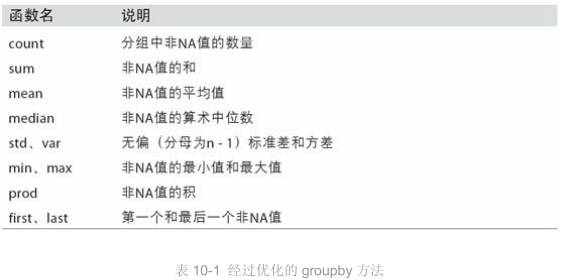

- 你可以使用__自己发明的 聚合运算__，
- 还可以调用__分组对象上 已经定义好的 任何方法__。例如，__quantile__可以计算__Series或DataFrame 列__的__样本分位数__。

虽然__quantile__并__没有明确地__实现于__GroupBy__，但它是一个__Series方法__，所以这里是__能用__的。实际上，__GroupBy__会__高效地 对Series 进行切片__，然后对__各片__调用__piece.quantile(0.9)__，最后将__这些结果 组装成 最终结果__：

In [40]:
df

,key1,key2,data1,data2
0,a,one,0.319679,-1.054333
1,a,two,2.048880,1.130118
2,b,one,-1.009887,0.464170
3,b,two,-0.064568,0.179669
4,a,one,-1.176650,1.287164


In [42]:
grouped = df.groupby('key1')

In [43]:
grouped['data1'].quantile(0.9)

key1
a    1.70304
b   -0.15910
Name: data1, dtype: float64

- 如果要使用你__自己的 聚合函数__，只需将其传入__aggregate或agg方法__即可：

In [44]:
def peak_to_peak(arr):
    return arr.max() - arr.min()

In [45]:
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,3.225531,2.341497
b,0.945319,0.284501


- 你可能注意到，__有些方法__(如__describe__)也是可以__用在这里__的，__即使严格来讲__，它们__并非 聚合运算__：

In [46]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.397303  1.614166 -1.176650 -0.428486  0.319679  1.184280   
b      2.0 -0.537228  0.668441 -1.009887 -0.773558 -0.537228 -0.300898   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     2.048880   3.0  0.454317  1.308886 -1.054333  0.037893  1.130118   
b    -0.064568   2.0  0.321919  0.201173  0.179669  0.250794  0.321919   

                          
           75%       max  
key1                      
a     1.208641  1.287164  
b     0.393045  0.464170

在后面的__10.3节__，将__详细说明__这到底是怎么回事。

笔记：__自定义聚合函数__要比__表10-1__中那些__经过优化的函数 慢得多__。这是因为在__构造 中间分组数据块__时存在__非常大的开销__(__函数调用、数据重排等__)。

## 2.1 面向列的多函数应用

回到前面小费的例子。使用read_csv导入数据之后，我们添加了一个__小费百分比的 列tip_pct__：

In [47]:
tips = pd.read_csv('examples/tips.csv')

In [48]:
tips['tip_pct'] = tips['tip'] / tips['total_bill']

tips[:6]

,total_bill,tip,smoker,day,time,size,tip_pct
0,16.99,1.01,No,Sun,Dinner,2,0.059447
1,10.34,1.66,No,Sun,Dinner,3,0.160542
2,21.01,3.50,No,Sun,Dinner,3,0.166587
3,23.68,3.31,No,Sun,Dinner,2,0.139780
4,24.59,3.61,No,Sun,Dinner,4,0.146808
5,25.29,4.71,No,Sun,Dinner,4,0.186240


你已经看到，对__Series或DataFrame列 的 聚合运算__其实就是使用__aggregate__(使用__自定义函数__)或调用__诸如mean、std之类的方法__。

- 然而，你可能希望对__不同的列__使用__不同的聚合函数__，或__一次应用 多个函数__。

其实这也好办，将通过一些示例来进行讲解。首先，根据__day和smoker__对__tips__进行__分组__：

In [49]:
grouped = tips.groupby(['day', 'smoker'])

- 注意，对于__表10-1__中的那些__描述统计__，可以将__函数名__以__字符串__的形式__传入__：

In [50]:
grouped_pct = grouped['tip_pct']

grouped_pct.agg('mean')

day   smoker
Fri   No        0.151650
      Yes       0.174783
Sat   No        0.158048
      Yes       0.147906
Sun   No        0.160113
      Yes       0.187250
Thur  No        0.160298
      Yes       0.163863
Name: tip_pct, dtype: float64

- 如果传入__一组 函数或函数名__，得到的__DataFrame的列__就会以__相应的 函数命名__：

In [52]:
grouped_pct.agg(['mean', 'std', peak_to_peak])

mean       std  peak_to_peak
day  smoker                                  
Fri  No      0.151650  0.028123      0.067349
     Yes     0.174783  0.051293      0.159925
Sat  No      0.158048  0.039767      0.235193
     Yes     0.147906  0.061375      0.290095
Sun  No      0.160113  0.042347      0.193226
     Yes     0.187250  0.154134      0.644685
Thur No      0.160298  0.038774      0.193350
     Yes     0.163863  0.039389      0.151240

这里，我们传递了__一组聚合函数 进行聚合__，__独立__对__数据分组__进行__评估__。

你并非一定要接受__GroupBy自动给出的 那些列名__，特别是__lambda函数__，它们的名称是'<lambda>'，这样的__辨识度__就__很低__了(通过__函数的 name属性__看看就知道了)。
- 因此，如果传入的是一个由__(name,function)元组__组成的__列表__，则__各元组__的__第一个元素__就会被用作__DataFrame 的列名__(可以将这种__二元元组列表__看做一个__有序映射__)：

In [53]:
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])

foo       bar
day  smoker                    
Fri  No      0.151650  0.028123
     Yes     0.174783  0.051293
Sat  No      0.158048  0.039767
     Yes     0.147906  0.061375
Sun  No      0.160113  0.042347
     Yes     0.187250  0.154134
Thur No      0.160298  0.038774
     Yes     0.163863  0.039389

- 对于__DataFrame__，你还有__更多选择__，你可以定义__一组 应用于全部列的 函数__，或__不同的列__应用__不同的函数__。

假设我们想要对__tip_pct和total_bill列__计算__三个统计信息__：

In [54]:
functions = ['count', 'mean', 'max']

In [56]:
result = grouped['tip_pct', 'total_bill'].agg(functions)

result

tip_pct                     total_bill                  
              count      mean       max      count       mean    max
day  smoker                                                         
Fri  No           4  0.151650  0.187735          4  18.420000  22.75
     Yes         15  0.174783  0.263480         15  16.813333  40.17
Sat  No          45  0.158048  0.291990         45  19.661778  48.33
     Yes         42  0.147906  0.325733         42  21.276667  50.81
Sun  No          57  0.160113  0.252672         57  20.506667  48.17
     Yes         19  0.187250  0.710345         19  24.120000  45.35
Thur No          45  0.160298  0.266312         45  17.113111  41.19
     Yes         17  0.163863  0.241255         17  19.190588  43.11

如你所见，__结果DataFrame__拥有__层次化的列__，这__相当于__分别对__各列__进行__聚合__，然后用__concat 将结果 组装__到一起，使用__列名__用作 __keys参数__：

In [57]:
result['tip_pct']

count      mean       max
day  smoker                           
Fri  No          4  0.151650  0.187735
     Yes        15  0.174783  0.263480
Sat  No         45  0.158048  0.291990
     Yes        42  0.147906  0.325733
Sun  No         57  0.160113  0.252672
     Yes        19  0.187250  0.710345
Thur No         45  0.160298  0.266312
     Yes        17  0.163863  0.241255

- 跟前面一样，这里也可以传入带有__自定义名称的 一组元组__：

In [58]:
ftuples = [('Durchschnitt', 'mean'),('Abweichung', np.var)]

In [59]:
grouped['tip_pct', 'total_bill'].agg(ftuples)

tip_pct              total_bill            
            Durchschnitt Abweichung Durchschnitt  Abweichung
day  smoker                                                 
Fri  No         0.151650   0.000791    18.420000   25.596333
     Yes        0.174783   0.002631    16.813333   82.562438
Sat  No         0.158048   0.001581    19.661778   79.908965
     Yes        0.147906   0.003767    21.276667  101.387535
Sun  No         0.160113   0.001793    20.506667   66.099980
     Yes        0.187250   0.023757    24.120000  109.046044
Thur No         0.160298   0.001503    17.113111   59.625081
     Yes        0.163863   0.001551    19.190588   69.808518

- 现在，假设你想要对__一个列 或 不同的列__应用__不同的函数__。具体的办法是向__agg__传入一个__从列名 映射到 函数 的字典__：

In [60]:
grouped.agg({'tip': np.max, 'size': 'sum'})

tip  size
day  smoker             
Fri  No       3.50     9
     Yes      4.73    31
Sat  No       9.00   115
     Yes     10.00   104
Sun  No       6.00   167
     Yes      6.50    49
Thur No       6.70   112
     Yes      5.00    40

In [61]:
grouped.agg({'tip_pct': ['min', 'max', 'mean', 'std'],
            'size': 'sum'})

tip_pct                               size
                  min       max      mean       std  sum
day  smoker                                             
Fri  No      0.120385  0.187735  0.151650  0.028123    9
     Yes     0.103555  0.263480  0.174783  0.051293   31
Sat  No      0.056797  0.291990  0.158048  0.039767  115
     Yes     0.035638  0.325733  0.147906  0.061375  104
Sun  No      0.059447  0.252672  0.160113  0.042347  167
     Yes     0.065660  0.710345  0.187250  0.154134   49
Thur No      0.072961  0.266312  0.160298  0.038774  112
     Yes     0.090014  0.241255  0.163863  0.039389   40

- 只有将__多个函数__应用到__至少一列__时，__DataFrame__才会拥有__层次化的列__。

## 2.2 以“没有行索引”的形式返回聚合数据

到__目前为止__，所有示例中的__聚合数据__都有由__唯一的 分组键__组成的__索引__(可能还是__层次化__的)。由于__并不总是需要如此__，所以你可以向 __groupby__传入__as_index=False__以__禁用__该功能：

In [62]:
tips.groupby(['day', 'smoker'], as_index=False).mean()

,day,smoker,total_bill,tip,size,tip_pct
0,Fri,No,18.420000,2.812500,2.250000,0.151650
1,Fri,Yes,16.813333,2.714000,2.066667,0.174783
2,Sat,No,19.661778,3.102889,2.555556,0.158048
3,Sat,Yes,21.276667,2.875476,2.476190,0.147906
4,Sun,No,20.506667,3.167895,2.929825,0.160113
5,Sun,Yes,24.120000,3.516842,2.578947,0.187250
6,Thur,No,17.113111,2.673778,2.488889,0.160298
7,Thur,Yes,19.190588,3.030000,2.352941,0.163863


当然，对__结果__调用__reset_index__也能得到__这种形式的 结果__。使用__as_index=False方法__可以__避免__一些__不必要的计算__。

# 3.apply：一般性的“拆分－应用－合并”

__最通用__的__GroupBy方法__是__apply__，__本节剩余部分__将__重点讲解__它。

如图10-2所示，__apply__会将__待处理的对象 拆分成 多个片段__，然后对__各片段 调用 传入的函数__，__最后__尝试将__各片段 组合__到一起。

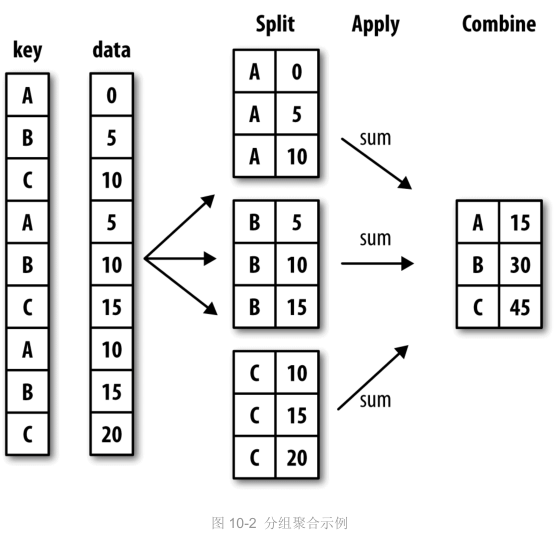

回到之前那个小费数据集，假设你想要__根据分组__选出__最高的 5个tip_pct值__。首先，编写一个__选取 指定列 具有最大值的行 的函数__：

In [63]:
def top(df, n=5, column='tip_pct'):
    return df.sort_values(by=column)[-n:]

In [64]:
top(tips, n=6)

,total_bill,tip,smoker,day,time,size,tip_pct
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
232,11.61,3.39,No,Sat,Dinner,2,0.291990
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


- 现在，如果对__smoker分组__并用__该函数__调用__apply__，就会得到：

In [65]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

这里发生了什么？__top函数__在__DataFrame的 各个片段上 调用__，然后__结果__由__pandas.concat 组装__到一起，并以__分组名称__进行了__标记__。于是，__最终结果__就有了一个__层次化索引__，其__内层索引值__来自__原DataFrame__。

- 如果__传给apply的 函数__能够接受__其他参数或关键字__，则可以将__这些内容__放在__函数名后面__一并__传入__：

In [66]:
tips.groupby(['smoker', 'day']).apply(top, n=1, column='total_bill')

total_bill    tip smoker   day    time  size   tip_pct
smoker day                                                             
No     Fri  94        22.75   3.25     No   Fri  Dinner     2  0.142857
       Sat  212       48.33   9.00     No   Sat  Dinner     4  0.186220
       Sun  156       48.17   5.00     No   Sun  Dinner     6  0.103799
       Thur 142       41.19   5.00     No  Thur   Lunch     5  0.121389
Yes    Fri  95        40.17   4.73    Yes   Fri  Dinner     4  0.117750
       Sat  170       50.81  10.00    Yes   Sat  Dinner     3  0.196812
       Sun  182       45.35   3.50    Yes   Sun  Dinner     3  0.077178
       Thur 197       43.11   5.00    Yes  Thur   Lunch     4  0.115982

笔记：除这些__基本用法__之外，能否充分发挥__apply的威力__很大程度上取决于__你的创造力__。__传入的那个函数__能做什么__全由你说了算__，它只需返回__一个pandas对象或标量值__即可。

__本章后续部分__的示例主要用于讲解__如何利用groupby__解决__各种各样的问题__。

可能你已经想起来了，之前在__GroupBy对象__上调用过__describe__：

In [67]:
result = tips.groupby('smoker')['tip_pct'].describe()

result

,count,mean,std,min,25%,50%,75%,max
smoker,,,,,,,,
No,151.0,0.159328,0.039910,0.056797,0.136906,0.155625,0.185014,0.291990
Yes,93.0,0.163196,0.085119,0.035638,0.106771,0.153846,0.195059,0.710345


In [68]:
result.unstack()

       smoker
count  No        151.000000
       Yes        93.000000
mean   No          0.159328
       Yes         0.163196
std    No          0.039910
       Yes         0.085119
min    No          0.056797
       Yes         0.035638
25%    No          0.136906
       Yes         0.106771
50%    No          0.155625
       Yes         0.153846
75%    No          0.185014
       Yes         0.195059
max    No          0.291990
       Yes         0.710345
dtype: float64

- 在__GroupBy__中，当你调用诸如__describe之类的方法__时，__实际上__只是应用了下面__两条代码的 快捷方式__而已：

In [70]:
f = lambda x: x.describe()

grouped['tip_pct'].apply(f)

day   smoker       
Fri   No      count     4.000000
              mean      0.151650
              std       0.028123
              min       0.120385
              25%       0.137239
              50%       0.149241
              75%       0.163652
              max       0.187735
      Yes     count    15.000000
              mean      0.174783
              std       0.051293
              min       0.103555
              25%       0.133739
              50%       0.173913
              75%       0.209240
              max       0.263480
Sat   No      count    45.000000
              mean      0.158048
              std       0.039767
              min       0.056797
              25%       0.136240
              50%       0.150152
              75%       0.183915
              max       0.291990
      Yes     count    42.000000
              mean      0.147906
              std       0.061375
              min       0.035638
              25%       0.091797
              50%      

## 3.1 禁止分组键

从上面的例子中可以看出，__分组键__会跟__原始对象的索引 共同构成 结果对象中的 层次化索引__。
- 将__group_keys=False__传入__groupby__即可__禁止该效果__：

In [71]:
# 禁止分组键
tips.groupby('smoker', group_keys=False).apply(top)

,total_bill,tip,smoker,day,time,size,tip_pct
88,24.71,5.85,No,Thur,Lunch,2,0.236746
185,20.69,5.00,No,Sun,Dinner,5,0.241663
51,10.29,2.60,No,Sun,Dinner,2,0.252672
149,7.51,2.00,No,Thur,Lunch,2,0.266312
232,11.61,3.39,No,Sat,Dinner,2,0.291990
109,14.31,4.00,Yes,Sat,Dinner,2,0.279525
183,23.17,6.50,Yes,Sun,Dinner,4,0.280535
67,3.07,1.00,Yes,Sat,Dinner,1,0.325733
178,9.60,4.00,Yes,Sun,Dinner,2,0.416667
172,7.25,5.15,Yes,Sun,Dinner,2,0.710345


In [72]:
# 禁止行索引
tips.groupby('smoker', as_index=False).apply(top)

total_bill   tip smoker   day    time  size   tip_pct
0 88        24.71  5.85     No  Thur   Lunch     2  0.236746
  185       20.69  5.00     No   Sun  Dinner     5  0.241663
  51        10.29  2.60     No   Sun  Dinner     2  0.252672
  149        7.51  2.00     No  Thur   Lunch     2  0.266312
  232       11.61  3.39     No   Sat  Dinner     2  0.291990
1 109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
  183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
  67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
  178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
  172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

In [73]:
tips.groupby('smoker').apply(top)

total_bill   tip smoker   day    time  size   tip_pct
smoker                                                           
No     88        24.71  5.85     No  Thur   Lunch     2  0.236746
       185       20.69  5.00     No   Sun  Dinner     5  0.241663
       51        10.29  2.60     No   Sun  Dinner     2  0.252672
       149        7.51  2.00     No  Thur   Lunch     2  0.266312
       232       11.61  3.39     No   Sat  Dinner     2  0.291990
Yes    109       14.31  4.00    Yes   Sat  Dinner     2  0.279525
       183       23.17  6.50    Yes   Sun  Dinner     4  0.280535
       67         3.07  1.00    Yes   Sat  Dinner     1  0.325733
       178        9.60  4.00    Yes   Sun  Dinner     2  0.416667
       172        7.25  5.15    Yes   Sun  Dinner     2  0.710345

## 3.2 分位数和桶分析

曾在__第7章__中讲过，__pandas__有一些能根据__指定面元或样本分位数 将数据 拆分成 多块的工具__(比如__cut和qcut__)。

- 将__这些函数__跟__groupby 结合__起来，就能非常轻松地实现对__数据集__的__桶(bucket)或分位数(quantile)分析__了。

以下面这个简单的__随机数据集__为例，我们利用__cut__将其装入__长度相等__的__桶__中：

In [74]:
frame = pd.DataFrame({'data1': np.random.randn(1000),
                     'data2': np.random.randn(1000)})
frame.head()

,data1,data2
0,-1.011352,0.182647
1,0.958418,1.211121
2,2.193845,-0.290195
3,-0.770597,-0.345367
4,-1.427448,-0.137093


In [75]:
quartiles = pd.cut(frame.data1, 4)

quartiles[:10]

0    (-1.613, 0.0512]
1     (0.0512, 1.716]
2       (1.716, 3.38]
3    (-1.613, 0.0512]
4    (-1.613, 0.0512]
5     (0.0512, 1.716]
6     (0.0512, 1.716]
7    (-1.613, 0.0512]
8     (0.0512, 1.716]
9    (-1.613, 0.0512]
Name: data1, dtype: category
Categories (4, interval[float64]): [(-3.284, -1.613] < (-1.613, 0.0512] < (0.0512, 1.716] < (1.716, 3.38]]

- 由__cut__返回的__Categorical对象__可__直接传递__到__groupby__。

因此，我们可以像下面这样对__data2列__做一些__统计计算__：

In [76]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
           'count': group.count(), 'mean': group.mean()}

In [78]:
grouped = frame.data2.groupby(quartiles)

grouped

In [79]:
grouped.apply(get_stats)

data1                  
(-3.284, -1.613]  count     51.000000
                  max        2.153618
                  mean      -0.197603
                  min       -2.108458
(-1.613, 0.0512]  count    461.000000
                  max        2.761727
                  mean       0.036303
                  min       -3.236985
(0.0512, 1.716]   count    442.000000
                  max        2.876604
                  mean       0.036565
                  min       -2.779638
(1.716, 3.38]     count     46.000000
                  max        1.583768
                  mean      -0.047620
                  min       -1.977462
Name: data2, dtype: float64

In [80]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
"(-3.284, -1.613]",51.0,2.153618,-0.197603,-2.108458
"(-1.613, 0.0512]",461.0,2.761727,0.036303,-3.236985
"(0.0512, 1.716]",442.0,2.876604,0.036565,-2.779638
"(1.716, 3.38]",46.0,1.583768,-0.047620,-1.977462


这些都是__长度相等的 桶__。
- 要根据__样本分位数__得到__大小相等的 桶__，使用__qcut__即可。传入__labels=False__即可只获取__分位数的编号__：

In [84]:
grouping = pd.qcut(frame.data1, 10, labels=False)

grouping[:5]

0    1
1    8
2    9
3    2
4    0
Name: data1, dtype: int64

In [86]:
grouped = frame.data2.groupby(grouping)

grouped

In [87]:
grouped.apply(get_stats).unstack()

,count,max,mean,min
data1,,,,
0,100.0,2.495505,0.018734,-2.108458
1,100.0,2.761727,-0.095325,-2.613068
2,100.0,2.060192,-0.002559,-2.556706
3,100.0,2.649165,0.149028,-3.180778
4,100.0,1.997319,-0.038379,-3.236985
5,100.0,2.384573,0.027554,-2.779638
6,100.0,2.336795,0.152461,-2.011472
7,100.0,2.840029,0.014829,-2.298091
8,100.0,2.733967,0.003023,-2.141477


我们会在__第12章__详细讲解__pandas__的__Categorical类型__。

## 3.3 示例：用特定于分组的值填充缺失值

对于__缺失数据__的__清理__工作，
- 有时你会用__dropna__将其__替换__掉，
- 而有时则可能会希望用__一个固定值__或由__数据集本身__所__衍生__出来的**值**去__填充NA值__。这时就得使用__fillna__这个工具了。

在下面这个例子中，用__平均值__去__填充NA值__：

In [88]:
s = pd.Series(np.random.randn(6))

s[::2] = np.nan

s

0         NaN
1    1.449655
2         NaN
3   -1.510018
4         NaN
5   -1.533015
dtype: float64

In [89]:
s.fillna(s.mean())

0   -0.531126
1    1.449655
2   -0.531126
3   -1.510018
4   -0.531126
5   -1.533015
dtype: float64

假设你需要对__不同的分组__填充__不同的值__。
- __一种方法__是将__数据分组__，并使用__apply__和一个能够对__各数据块 调用 fillna 的函数__即可。

下面是一些有关美国几个州的示例数据，这些州又被分为东部和西部：

In [90]:
states = ['Ohio', 'New York', 'Vermont', 'Florida', 'Oregon', 'Nevada', 'California', 'Idaho']

In [91]:
group_key = ['East'] * 4 + ['West'] * 4

group_key

['East', 'East', 'East', 'East', 'West', 'West', 'West', 'West']

In [92]:
data = pd.Series(np.random.randn(8), index=states)

data

Ohio         -0.059041
New York     -2.479287
Vermont       0.737980
Florida       0.409924
Oregon        0.908823
Nevada        0.048226
California    0.543223
Idaho        -0.469909
dtype: float64

['East'] * 4 产生了一个列表，包括了['East']中元素的四个拷贝。将这些列表串联起来。

将一些值设为缺失：

In [93]:
data[['Vermont', 'Nevada', 'Idaho']] = np.nan

data

Ohio         -0.059041
New York     -2.479287
Vermont            NaN
Florida       0.409924
Oregon        0.908823
Nevada             NaN
California    0.543223
Idaho              NaN
dtype: float64

In [94]:
data.groupby(group_key).mean()

East   -0.709468
West    0.726023
dtype: float64

- 我们可以用__分组平均值__去__填充NA值__:

In [95]:
fill_mean = lambda g: g.fillna(g.mean())

data.groupby(group_key).apply(fill_mean)

Ohio         -0.059041
New York     -2.479287
Vermont      -0.709468
Florida       0.409924
Oregon        0.908823
Nevada        0.726023
California    0.543223
Idaho         0.726023
dtype: float64

- 除此之外，也可以__在代码中 预定义 各组的填充值__。由于__分组__具有一个__name属性__，所以我们可以拿来用一下：

In [96]:
fill_values = {'East': 0.5, 'West': -1}

fill_func = lambda g: g.fillna(fill_values[g.name])

In [97]:
data.groupby(group_key).apply(fill_func)

Ohio         -0.059041
New York     -2.479287
Vermont       0.500000
Florida       0.409924
Oregon        0.908823
Nevada       -1.000000
California    0.543223
Idaho        -1.000000
dtype: float64

## 3.4 示例：随机采样和排列

假设你想要从一个__大数据集__中__随机抽取__(进行__替换或不替换__)__样本__以进行__蒙特卡罗模拟__(Monte Carlo simulation)或__其他分析工作__。

- __“抽取”__的__方式__有__很多__，这里使用的方法是对__Series__使用__sample方法__：

In [100]:
# Hearts, Spades, Clubs, Diamonds
suits = ['H', 'S', 'C', 'D']

card_val = (list(range(1, 11)) + [10] * 3) * 4

base_names = ['A'] + list(range(2, 11)) + ['J', 'K', 'Q']

In [102]:
cards = []

for suit in suits:
    cards.extend(str(num) + suit for num in base_names)

cards[:5]

['AH', '2H', '3H', '4H', '5H']

In [103]:
deck = pd.Series(card_val, index=cards)

现在有了一个__长度为52__的__Series__，其__索引__包括__牌名__，**值**则是21点或其他游戏中__用于计分的 点数__(为了简单起见，当A的点数为1)：

In [104]:
deck[:13]

AH      1
2H      2
3H      3
4H      4
5H      5
6H      6
7H      7
8H      8
9H      9
10H    10
JH     10
KH     10
QH     10
dtype: int64

- 现在，根据上面所讲的，从__整副牌__中__抽出5张__，代码如下：

In [105]:
def draw(deck, n=5):
    return deck.sample(n)

In [106]:
draw(deck)

10D    10
KC     10
2C      2
6H      6
QS     10
dtype: int64

- 假设你想要从__每种花色__中__随机抽取 两张牌__。由于花色是牌名的最后一个字符，所以我们可以据此进行__分组__，并使用__apply__：

In [108]:
get_suit = lambda card: card[-1] # last letter is suit

deck.groupby(get_suit).apply(draw, n=2)

C  2C     2
   8C     8
D  3D     3
   KD    10
H  3H     3
   4H     4
S  3S     3
   6S     6
dtype: int64

- 或者，也可以这样写：

In [109]:
deck.groupby(get_suit, group_keys=False).apply(draw, n=2)

5C      5
10C    10
8D      8
AD      1
9H      9
10H    10
AS      1
2S      2
dtype: int64

## 3.5 分组加权平均数和相关系数

根据__groupby__的__“拆分－应用－合并”范式__，可以进行__DataFrame的 列与列之间__或__两个Series之间__的__运算__(比如__分组加权平均__)。

以下面这个数据集为例，它含有__分组键__、__值__以及一些**权重值**：

In [110]:
df = pd.DataFrame({'category': ['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'],
                  'data': np.random.randn(8),
                  'weights': np.random.randn(8)})

df

,category,data,weights
0,a,-0.482048,-0.045522
1,a,-0.268952,-0.111860
2,a,0.376748,-0.256143
3,a,-0.119047,-1.362712
4,b,-1.043926,0.497831
5,b,0.676330,-1.009107
6,b,-0.184048,-0.750906
7,b,0.873756,-0.150417


- 然后可以利用__category__计算__分组加权平均数__：

In [111]:
grouped = df.groupby('category')

get_wavg = lambda g: np.average(g['data'], weights=g['weights'])

In [112]:
grouped.apply(get_wavg)

category
a   -0.066294
b    0.846251
dtype: float64

另一个例子，考虑一个来自Yahoo!Finance的数据集，其中含有__几只股票__和__标准普尔500指数__(符号__SPX__)的__收盘价__：

In [117]:
close_px = pd.read_csv('examples/stock_px_2.csv', parse_dates=True, index_col=0)

In [118]:
close_px.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2214 entries, 2003-01-02 to 2011-10-14
Data columns (total 4 columns):
AAPL    2214 non-null float64
MSFT    2214 non-null float64
XOM     2214 non-null float64
SPX     2214 non-null float64
dtypes: float64(4)
memory usage: 86.5 KB


In [119]:
close_px[-4:]

,AAPL,MSFT,XOM,SPX
2011-10-11,400.29,27.00,76.27,1195.54
2011-10-12,402.19,26.96,77.16,1207.25
2011-10-13,408.43,27.18,76.37,1203.66
2011-10-14,422.00,27.27,78.11,1224.58


- 来做一个比较有趣的任务：计算一个由__日收益率__(通过__百分数变化__计算)与__SPX__之间的__年度相关系数__组成的__DataFrame__。

下面是一个实现办法，我们先创建一个__函数__，用它计算__每列__和__SPX列__的__成对相关系数__：

In [120]:
spx_corr = lambda x: x.corrwith(x['SPX'])

接下来，我们使用__pct_change__计算__close_px__的__百分比变化__：

In [125]:
rets = close_px.pct_change().dropna()

rets.head()

,AAPL,MSFT,XOM,SPX
2003-01-03,0.006757,0.001421,0.000684,-0.000484
2003-01-06,0.000000,0.017975,0.024624,0.022474
2003-01-07,-0.002685,0.019052,-0.033712,-0.006545
2003-01-08,-0.020188,-0.028272,-0.004145,-0.014086
2003-01-09,0.008242,0.029094,0.021159,0.019386


最后，我们用**年**对__百分比变化__进行__分组__，可以用一个一行的__函数__，从__每行的标签__返回__每个datetime标签__的__year属性__：

In [127]:
get_year = lambda x: x.year

by_year = rets.groupby(get_year)

In [128]:
by_year.apply(spx_corr)

,AAPL,MSFT,XOM,SPX
2003,0.541124,0.745174,0.661265,1.0
2004,0.374283,0.588531,0.557742,1.0
2005,0.467540,0.562374,0.631010,1.0
2006,0.428267,0.406126,0.518514,1.0
2007,0.508118,0.658770,0.786264,1.0
2008,0.681434,0.804626,0.828303,1.0
2009,0.707103,0.654902,0.797921,1.0
2010,0.710105,0.730118,0.839057,1.0
2011,0.691931,0.800996,0.859975,1.0


当然，你还可以计算__列与列之间__的__相关系数__。这里，我们计算Apple和Microsoft的__年相关系数__：

In [129]:
by_year.apply(lambda g: g["AAPL"].corr(g["MSFT"]))

2003    0.480868
2004    0.259024
2005    0.300093
2006    0.161735
2007    0.417738
2008    0.611901
2009    0.432738
2010    0.571946
2011    0.581987
dtype: float64

## 3.6 示例：组级别的线性回归

顺着上一个例子继续，你可以用__groupby__执行__更为复杂__的__分组统计分析__，只要__函数__返回的是__pandas对象或标量值__即可。

例如，可以定义下面这个__regress函数__(利用__statsmodels计量经济学库__)对__各数据块__执行__普通最小二乘法__(Ordinary Least Squares，OLS)__回归__：

In [130]:
import statsmodels.api as sm

In [137]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1
    result = sm.OLS(Y, X).fit()
    return result.params

现在，为了__按年__计算__AAPL对SPX 收益率的 线性回归__，执行：

In [138]:
by_year.apply(regress, 'AAPL', ['SPX'])

,SPX,intercept
2003,1.195406,0.000710
2004,1.363463,0.004201
2005,1.766415,0.003246
2006,1.645496,0.000080
2007,1.198761,0.003438
2008,0.968016,-0.001110
2009,0.879103,0.002954
2010,1.052608,0.001261
2011,0.806605,0.001514


# 4. 透视表和交叉表

## 4.1 透视表

__透视表__(pivot table)是__各种电子表格程序__和__其他数据分析软件__中一种__常见__的__数据汇总工具__。它根据__一个或多个键__对__数据__进行__聚合__，并根据__行和列上的 分组键__将__数据__分配到__各个矩形区域__中。

- 在__Python和pandas__中，可以通过本章所介绍的__groupby功能 以及 (能够利用 层次化索引的)重塑运算__制作__透视表__。

- __DataFrame__有一个__pivot_table方法__，此外还有一个__顶级__的__pandas.pivot_table函数__。除能为__groupby__提供__便利__之外，**pivot_table**还可以添加__分项小计__，也叫做**margins**。

回到小费数据集，
- 假设想要根据__day和smoker__计算__分组平均数__(__pivot_table__的__默认聚合类型__)，并将__day和smoker__放到__行__上：

In [139]:
tips.pivot_table(index=['day', 'smoker'])

size       tip   tip_pct  total_bill
day  smoker                                          
Fri  No      2.250000  2.812500  0.151650   18.420000
     Yes     2.066667  2.714000  0.174783   16.813333
Sat  No      2.555556  3.102889  0.158048   19.661778
     Yes     2.476190  2.875476  0.147906   21.276667
Sun  No      2.929825  3.167895  0.160113   20.506667
     Yes     2.578947  3.516842  0.187250   24.120000
Thur No      2.488889  2.673778  0.160298   17.113111
     Yes     2.352941  3.030000  0.163863   19.190588

可以用__groupby 直接来做__。
- 现在，假设我们只想__聚合tip_pct和size__，而且想根据__time__进行__分组__。将__smoker__放到**列**上，把__day__放到__行__上：

In [142]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'], columns='smoker')

size             tip_pct          
smoker             No       Yes        No       Yes
time   day                                         
Dinner Fri   2.000000  2.222222  0.139622  0.165347
       Sat   2.555556  2.476190  0.158048  0.147906
       Sun   2.929825  2.578947  0.160113  0.187250
       Thur  2.000000       NaN  0.159744       NaN
Lunch  Fri   3.000000  1.833333  0.187735  0.188937
       Thur  2.500000  2.352941  0.160311  0.163863

- 还可以对__这个表__作__进一步__的__处理__，传入__margins=True__添加__分项小计__。

这将会添加__标签为All的 行和列__，其**值**对应于__单个等级__中__所有数据__的__分组统计__：

In [143]:
tips.pivot_table(['tip_pct', 'size'], index=['time', 'day'], columns='smoker', margins=True)

size                       tip_pct                    
smoker             No       Yes       All        No       Yes       All
time   day                                                             
Dinner Fri   2.000000  2.222222  2.166667  0.139622  0.165347  0.158916
       Sat   2.555556  2.476190  2.517241  0.158048  0.147906  0.153152
       Sun   2.929825  2.578947  2.842105  0.160113  0.187250  0.166897
       Thur  2.000000       NaN  2.000000  0.159744       NaN  0.159744
Lunch  Fri   3.000000  1.833333  2.000000  0.187735  0.188937  0.188765
       Thur  2.500000  2.352941  2.459016  0.160311  0.163863  0.161301
All          2.668874  2.408602  2.569672  0.159328  0.163196  0.160803

这里，__All值__为__平均数__：__不单独考虑__烟民与非烟民(__All列__)，__不单独考虑__ 行分组//两个级别中的//任何单项(__All行__)。

- 要使用__其他__的__聚合函数__，将其传给__aggfunc__即可。

例如，使用__count或len__可以得到__有关分组大小__的__交叉表__(__计数或频率__)：

In [145]:
tips.pivot_table('tip_pct', index=['time', 'smoker'], columns='day', aggfunc=len, margins=True)

day             Fri   Sat   Sun  Thur    All
time   smoker                               
Dinner No       3.0  45.0  57.0   1.0  106.0
       Yes      9.0  42.0  19.0   NaN   70.0
Lunch  No       1.0   NaN   NaN  44.0   45.0
       Yes      6.0   NaN   NaN  17.0   23.0
All            19.0  87.0  76.0  62.0  244.0

- 如果存在__空的组合__(也就是__NA__)，你可能会希望设置一个__fill_value__：

In [156]:
tips.pivot_table('tip_pct', index=['time', 'size', 'smoker'], columns='day', aggfunc='mean', fill_value=0)

day                      Fri       Sat       Sun      Thur
time   size smoker                                        
Dinner 1    No      0.000000  0.137931  0.000000  0.000000
            Yes     0.000000  0.325733  0.000000  0.000000
       2    No      0.139622  0.162705  0.168859  0.159744
            Yes     0.171297  0.148668  0.207893  0.000000
       3    No      0.000000  0.154661  0.152663  0.000000
            Yes     0.000000  0.144995  0.152660  0.000000
       4    No      0.000000  0.150096  0.148143  0.000000
            Yes     0.117750  0.124515  0.193370  0.000000
       5    No      0.000000  0.000000  0.206928  0.000000
            Yes     0.000000  0.106572  0.065660  0.000000
       6    No      0.000000  0.000000  0.103799  0.000000
Lunch  1    No      0.000000  0.000000  0.000000  0.181728
            Yes     0.223776  0.000000  0.000000  0.000000
       2    No      0.000000  0.000000  0.000000  0.166005
            Yes     0.181969  0.000000  0.000000  0.158843
       3    No      0.187735  0.000000  0.000000  0.084246
            Yes     0.000000  0.000000  0.000000  0.204952
       4    No      0.000000  0.000000  0.000000  0.138919
            Yes     0.000000  0.000000  0.000000  0.155410
       5    No      0.000000  0.000000  0.000000  0.121389
       6    No      0.000000  0.000000  0.000000  0.173706

__pivot_table__的__参数__说明请参见表10-2。

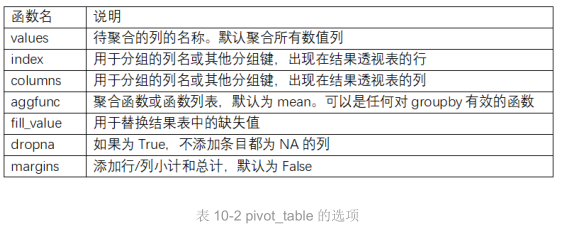

## 4.2 交叉表

__交叉表__(cross-tabulation，简称crosstab)是一种用于计算__分组频率__的__特殊透视表__。看下面的例子：

In [165]:
data = pd.DataFrame({'Sample': range(1,11),
                    'Nationality': ['USA', 'Japan', 'USA', 'Japan', 'Japan', 'Japan', 'USA', 'USA', 'Japan', 'USA'],
                    'Handedness': ['Right_handed', 'Left-handed', 'Right_handed', 'Right_handed', 'Left-handed', 'Right_handed', \
                                   'Right_handed', 'Left-handed', 'Right_handed', 'Right_handed']})
data

,Sample,Nationality,Handedness
0,1,USA,Right_handed
1,2,Japan,Left-handed
2,3,USA,Right_handed
3,4,Japan,Right_handed
4,5,Japan,Left-handed
5,6,Japan,Right_handed
6,7,USA,Right_handed
7,8,USA,Left-handed
8,9,Japan,Right_handed
9,10,USA,Right_handed


作为__调查分析__的一部分，我们可能想要根据__国籍__和__用手习惯__对这段数据进行__统计汇总__。
- 虽然可以用__pivot_table__实现__该功能__，但是__pandas.crosstab函数__会__更方便__：

In [166]:
pd.crosstab(data.Nationality, data.Handedness, margins=True)

Handedness,Left-handed,Right_handed,All
Nationality,,,
Japan,2,3,5
USA,1,4,5
All,3,7,10


In [171]:
# 使用pivot_table实现
data.pivot_table(index='Nationality', columns='Handedness', aggfunc=len, margins=True)

Sample                 
Handedness  Left-handed Right_handed All
Nationality                             
Japan                 2            3   5
USA                   1            4   5
All                   3            7  10

- __crosstab__的__前两个参数__可以是__数组或Series__，或是__数组列表__。

就像小费数据：

In [163]:
pd.crosstab([tips.time, tips.day], tips.smoker, margins=True)

smoker        No  Yes  All
time   day                
Dinner Fri     3    9   12
       Sat    45   42   87
       Sun    57   19   76
       Thur    1    0    1
Lunch  Fri     1    6    7
       Thur   44   17   61
All          151   93  244

# 5.总结

掌握__pandas 数据分组工具__既有助于__数据清理__，也有助于__建模或统计分析工作__。在__第14章__，我们会看__几个例子__，对__真实数据__使用__groupby__。

在__下一章__，我们将关注__时间序列数据__。